In [ ]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc

from jaxbo.models import DeepMultifidelityGP
from jaxbo.utils import normalize_MultifidelityGP, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [ ]:
# from jaxbo.input_priors import uniform_prior

# def test():
#     dim = 1
#     lb = np.zeros(dim)
#     ub = np.ones(dim)
#     p_x = uniform_prior(lb, ub)
#     def rho(x):
# #         return 0.5*x
#         return 10.0*(x<5.0) + 2.0*x
#     def f_H(x):
#         x = x.flatten()
#         y = (6.0*x-2.0)**2 * np.sin(12.0*x-4.0)
#         return y[0]
#     def f_L(x):
#         x = x.flatten()
#         y = rho(f_H(x)) + 10.0*(x-0.5) - 5.0
#         return y[0]
#     return (f_L, f_H), p_x, dim, lb, ub

In [ ]:
f, p_x, dim, lb, ub = jump_forrester()
f_L, f_H = f

# Problem setttings
NL = 50
NH = 8
noiseL = 0.0
noiseH = 0.0
if 1==1: #Activate to use MomentumResNet
    options = {'kernel': 'RBF',
               'input_prior': p_x,
               'net_arch': 'MomentumResNet',
               'depth': 2,
               'vel_zeros': 0,
               'gamma': 0.9}
    layers = [1, 20, 20, 1]
    gp_model = DeepMultifidelityGP(options, layers)
if 1==0: #Activate to use ResNet
    options = {'kernel': 'RBF',
               'input_prior': p_x,
               'net_arch': 'ResNet',
               'depth': 2,
               'is_spect': 0}
    layers = [1, 20, 20, 1]
    gp_model = DeepMultifidelityGP(options, layers)
if 1==0: # Activate to use MLP
    options = {'kernel': 'RBF',
               'input_prior': p_x,
               'net_arch': 'MLP'}
    layers = [1, 20, 20, 1]
    gp_model = DeepMultifidelityGP(options, layers)

# Fetch domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
XL = lb + (ub-lb)*lhs(dim, NL)
yL = vmap(f_L)(XL)
yL = yL + noiseL*yL.std(0)*onp.random.normal(yL.shape)

XH = lb + (ub-lb)*lhs(dim, NH)
yH = vmap(f_H)(XH)
yH = yH + noiseH*yH.std(0)*onp.random.normal(yH.shape)

y = np.concatenate([yL, yH])

# Test data
nn = 1000
X_star = np.linspace(lb[0], ub[0], nn)[:,None]
yL_star = vmap(f_L)(X_star)
yH_star = vmap(f_H)(X_star)

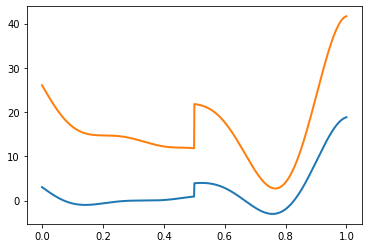

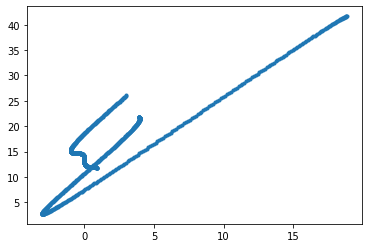

In [ ]:
plt.figure()
plt.plot(X_star, yL_star, lw = 2)
plt.plot(X_star, yH_star, lw = 2)

plt.figure()
plt.plot(yL_star, yH_star, '.')

In [ ]:
rng_key = random.PRNGKey(0)
# Fetch normalized training data
norm_batch, norm_const = normalize_MultifidelityGP(XL, yL, XH, yH, bounds)

# Train GP model
print('Train GP...')
rng_key = random.split(rng_key)[0]
opt_params = gp_model.train(norm_batch,
                            rng_key,
                            num_restarts = 20)

Train GP...


In [ ]:
kwargs = {'params': opt_params,
          'batch': norm_batch,
          'norm_const': norm_const,
          'bounds': bounds,
          'gmm_vars': None}
# Test accuracy
mean, std = gp_model.predict(X_star, **kwargs)
mean = mean * norm_const['sigma_y'] + norm_const['mu_y']
std = std * norm_const['sigma_y']
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-yH_star,2)/np.linalg.norm(yH_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 9.956947e-02


Text(0, 0.5, '$f(x)$')

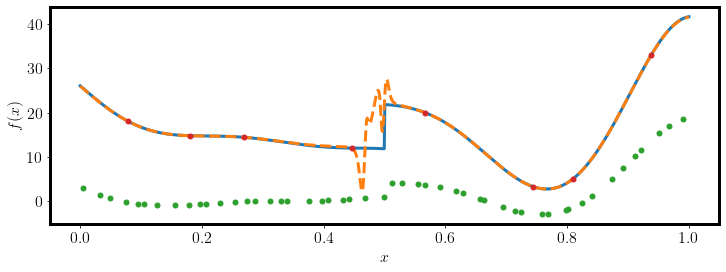

In [ ]:
# Convert to NumPy
X_star = onp.array(X_star)
yH_star = onp.array(yH_star)
mean = onp.array(mean)
std = onp.array(std)

# Plot
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth']=3
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

plt.figure(figsize = (12,4))
plt.plot(X_star, yH_star, lw = 3)
plt.plot(X_star, mean, '--', lw = 3)
plt.plot(XL, yL, '.', ms = 10)
plt.plot(XH, yH, '.', ms = 10)
# plt.fill_between(X_star.flatten(), lower, upper, 
#                  facecolor='orange', alpha=0.5, label="Two std band")
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')